# Probabilistic Time Series Analysis

## Week 5: Recurrent Neural Networks (Part 2)

Places where you are supposed to fill in code are marked

    #
    # TODO: some instructions
    # 
    
You will need to install the PyTorch package. You can find instructions here that will generate a pip or conda command for you to run:

- https://pytorch.org/get-started/locally/

# Setup

In [2]:
# ! pip install --user torch

    100% |████████████████████████████████| 519.5MB 153kB/s ta 0:00:011    38% |████████████▍                   | 200.2MB 8.9MB/s eta 0:00:36    48% |███████████████▋                | 254.1MB 12.0MB/s eta 0:00:23    88% |████████████████████████████▏   | 457.2MB 12.4MB/s eta 0:00:06


In [3]:
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import argparse
import os
import string
import random
import time
import math

from tqdm import tqdm

%matplotlib inline

In [4]:
# Reading and un-unicode-encoding data

all_characters = string.printable
n_characters = len(all_characters)

def read_file(filename):
    file = open(filename).read()
    return file, len(file)

# Turning a string into a tensor

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

# Readable time elapsed

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [5]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="gru", n_layers=1):
        super(CharRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def forward2(self, input, hidden):
        encoded = self.encoder(input.view(1, -1))
        output, hidden = self.rnn(encoded.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

In [6]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))

    if cuda:
        hidden = hidden.cuda()
        prime_input = prime_input.cuda()
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char).unsqueeze(0))
        if cuda:
            inp = inp.cuda()

    return predicted

# Select Dataset

In [7]:
filename = '../../data/holmes.txt'

file, file_len = read_file(filename)

# Training

In [341]:
#
# Hyperparameters
#

model = 'gru' #'gru' or 'lstm'
n_epochs = 1000
print_every = 50
hidden_size = 100 # 100, 50, 150, 200
n_layers = 2 # 2, 3, 4
learning_rate = 5e-3
chunk_len = 150 # 150, 50, 200, 300
batch_size = 100 # 40, 20, 60, 100

params_dict = {'model' : model,
               'n_epochs' : n_epochs, 
               'hidden_size' : hidden_size, 
               'n_layers' : n_layers, 
               'learning_rate' : learning_rate, 
               'chunk_len' : chunk_len, 
               'batch_size' : batch_size}

params = ['model', 'n_epochs', 'hidden_size', 'n_layers', 'learning_rate', 'chunk_len', 'batch_size']

In [342]:
def random_training_set(chunk_len, batch_size):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, file_len - chunk_len)
        end_index = start_index + chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    return inp, target

def train(inp, target):
    hidden = decoder.init_hidden(batch_size)
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len

# Initialize models and start training

decoder = CharRNN(
    n_characters,
    hidden_size,
    n_characters,
    model=model,
    n_layers=n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

try:
    print("Training for %d epochs..." % n_epochs)
    for epoch in tqdm(range(1, n_epochs + 1)):
        loss = train(*random_training_set(chunk_len, batch_size))
        loss_avg += loss
        all_losses.append(loss)
        
        if epoch % print_every == 0:
            print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
            print(generate(decoder, 'Wh', 100, cuda=False))
            print('\n')
except e:
    print(e)

  0%|          | 0/1000 [00:00<?, ?it/s]

Training for 1000 epochs...


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  5%|▌         | 50/1000 [00:34<10:46,  1.47it/s]

 34s (50 5%) 2.4636]
Whe opche famled ecthe whe ossey tas  adathat wo efitingy
whe to theiny the wangad of feln in ous fon 




 10%|█         | 100/1000 [01:08<10:26,  1.44it/s]

 8s (100 10%) 2.1898]
Wh thore mish lotigid, he at wad om and Mast and Seromily ot ad mouth   enbin he ame ame the as to bid




 15%|█▌        | 150/1000 [01:44<09:43,  1.46it/s]

 44s (150 15%) 2.0211]
Who derevoth that inpert he hearly and ictiun arion and were ond, the liver fror the and surclling som




 20%|██        | 200/1000 [02:20<09:45,  1.37it/s]

 20s (200 20%) 1.8978]
Whatly of the ctous is Lease deat, ut ster spacn and the lave engter. All to the and ownsed and was th




 25%|██▌       | 250/1000 [02:59<10:38,  1.17it/s]

 59s (250 25%) 1.8509]
Wheil in murt to cword nopied toursts Anroutle.

seemst what in the may leganting came and the feentio




 30%|███       | 300/1000 [03:36<09:26,  1.24it/s]

 36s (300 30%) 1.8255]
Whobded to with seart in the manies on a drove very and on they inlard indith the destuburned, you lec




 35%|███▌      | 350/1000 [04:10<07:08,  1.52it/s]

 10s (350 35%) 1.7800]
Whe accected. The neultiers in selcenty, when the
but the somiticter troot the become to a said Stian 




 40%|████      | 400/1000 [04:46<06:33,  1.52it/s]

 46s (400 40%) 1.7217]
Whith Frence men with the put the seating to sign Ah And hem.

"And Natea_ whilating him?" said the
in




 45%|████▌     | 450/1000 [05:21<06:00,  1.52it/s]

 21s (450 45%) 1.7047]
Whrice a sticcial land, the
Frencise, and were that that reculle, and that though the meaned but to sl




 50%|█████     | 500/1000 [05:56<05:58,  1.40it/s]

 56s (500 50%) 1.6407]
Wh. "I the head. From are dook execally dremiers when a mowons the for
campared one. "In
the Engle, wh




 55%|█████▌    | 550/1000 [06:33<05:34,  1.35it/s]

 33s (550 55%) 1.6431]
Whe trackness in the present and any with the general francition on then he found lavled they are finj




 60%|██████    | 600/1000 [07:07<04:32,  1.47it/s]

 7s (600 60%) 1.6595]
Wh. supern who law are inflitis own that the wound they could fassant of I like
end those of some
wate




 65%|██████▌   | 650/1000 [07:45<03:57,  1.47it/s]

 45s (650 65%) 1.6741]
Whe and patient, for the control.

"The treath tay the rights was ogether what still he had said the
b




 70%|███████   | 700/1000 [08:21<03:41,  1.36it/s]

 21s (700 70%) 1.6516]
When the states that injurishs,
the posistion to the any orgent may brought bor to be sill to compasim




 75%|███████▌  | 750/1000 [08:56<02:57,  1.41it/s]

 56s (750 75%) 1.6146]
Whe strest if the
she for firming to precom which shumber in the starl, into the Prodening of Others, 




 80%|████████  | 800/1000 [09:32<02:16,  1.47it/s]

 32s (800 80%) 1.5617]
Whe proinevers of a pair to which have wound and may remarking indoverolle.

"How, draxizs to the ever




 85%|████████▌ | 850/1000 [10:09<01:58,  1.27it/s]

 9s (850 85%) 1.5821]
Wh. A sigetlies of the satission, and they was understood to octeriers and directions some did proaces




 90%|█████████ | 900/1000 [10:42<01:28,  1.13it/s]

 42s (900 90%) 1.5603]
When they was stand the good.

He don't was influde-such well, room.

"I lor in the gene to the Russea




 95%|█████████▌| 950/1000 [11:18<00:34,  1.44it/s]

 18s (950 95%) 1.5629]
Where thoughtered the straising states in crimation above nock from the servich complicions in the han




100%|██████████| 1000/1000 [11:54<00:00,  1.46it/s]

 54s (1000 100%) 1.5690]
When the wall it was on some after
ours. It reads the seacss--a subbation as vare norters a
dejection 




# Evaluation

In [87]:
# 
# TODO: The variable all_losses contains the per-epoch losses (these are longer time units than in the last lab).
# Plot these losses. Try changing the learning rate or other hyperparameters until you get different behavior, and
# plot those losses as well. What seems to affect the rate of decrease? Do you notice a difference from last time?
#

In [12]:
import numpy as np
import pandas as pd

## Params saving

In [343]:
params_dict['final_loss'] = all_losses[-1]
params_dict['all_losses'] = all_losses

In [344]:
# initializing eval_df

# eval_df = pd.DataFrame(columns=params + ['final_loss', 'all_losses'])

In [345]:
eval_df = eval_df.append(params_dict, ignore_index=True)
# eval_df.sort_values(by=['model', 'learning_rate'], inplace=True)
# eval_df.reset_index(drop=True, inplace=True)

In [347]:
# writing to csv file

eval_df.to_csv('eval_df.csv')

In [348]:
# reading from csv file

def str_to_float(x):
    if type(x) == float:
        return x
    elif x[0] == 't':
        if x[-1] == ',':
            return float(x[7:-2])
        else:
            return float(x[7:-1])
    else:
        if x[-1] == ',':
            return float(x[:-1])
        else:
            return float(x)

eval_df = pd.read_csv('eval_df.csv', index_col=0)
eval_df.final_loss = eval_df.final_loss.apply(str_to_float)
eval_df.all_losses = eval_df.all_losses.apply(lambda x: [str_to_float(el) for el in x[1:-1].split()])

In [349]:
eval_df

,model,n_epochs,hidden_size,n_layers,learning_rate,chunk_len,batch_size,final_loss,all_losses
0,gru,1000,100,2,0.001,150,40,1.722400,"[4.6367, 4.5918, 4.5429, 4.4928, 4.4436, 4.379..."
1,gru,1000,100,2,0.005,150,40,1.572700,"[4.5958, 4.326, 3.8635, 3.4169, 3.2148, 3.1517..."
2,gru,1000,100,2,0.010,150,40,1.557401,"[4.607749, 4.055163, 3.3172934, 3.2578216, 3.0..."
3,gru,1000,100,2,0.100,150,40,2.216300,"[4.6237, 5.4039, 3.8692, 5.7267, 4.6817, 4.968..."
4,lstm,1000,100,2,0.005,150,40,1.692400,"[4.6038, 4.4739, 4.121, 3.6058, 3.3124, 3.1668..."
5,lstm,1000,100,2,0.010,150,40,1.583200,"[4.5937, 4.3674, 3.5718, 3.2284, 3.1854, 3.204..."
6,lstm,1000,100,2,0.100,150,40,2.328400,"[4.5813, 3.6054, 4.4298, 3.5533, 4.0493, 3.262..."
7,gru,1000,50,2,0.005,150,40,1.815000,"[4.6146, 4.5215, 4.4022, 4.2152, 3.9392, 3.664..."
8,gru,1000,150,2,0.005,150,40,1.482400,"[4.6128, 4.2634, 3.5645, 3.2845, 3.1888, 3.124..."
9,gru,1000,200,2,0.005,150,40,1.443600,"[4.5974, 4.0601, 3.3549, 3.1845, 3.1223, 3.096..."


## Different learning rates (gru)

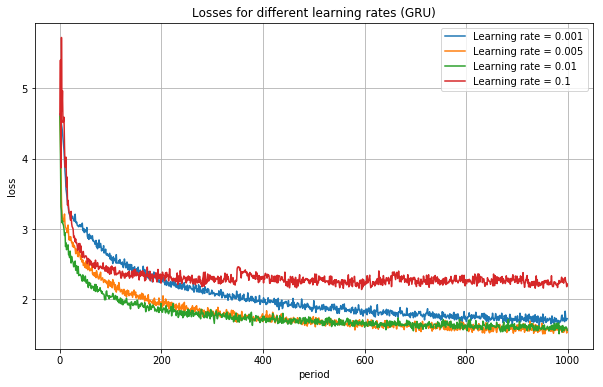

In [295]:
all_losses = np.array(eval_df.all_losses[0])
x = np.arange(0, all_losses.shape[0])

plt.figure(figsize=(10,6))
for i in [0, 1, 2, 3]:
    plt.plot(x, eval_df.all_losses[i], 
             label='Learning rate = '+str(round(eval_df.learning_rate[i], 4)))
plt.xlabel('period')
plt.ylabel('loss')
plt.title('Losses for different learning rates (GRU)')
plt.legend()

plt.grid()
plt.show()

## Different learning rates (lstm)

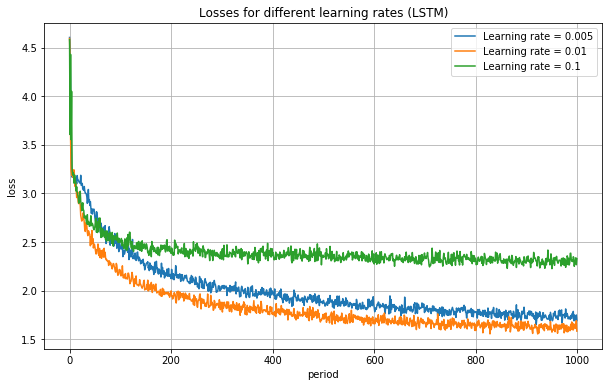

In [236]:
all_losses = np.array(eval_df.all_losses[0])
x = np.arange(0, all_losses.shape[0])

plt.figure(figsize=(10,6))
for i in [4, 5, 6]:
    plt.plot(x, eval_df.all_losses[i], 
             label='Learning rate = '+str(round(eval_df.learning_rate[i], 4)))
plt.xlabel('period')
plt.ylabel('loss')
plt.title('Losses for different learning rates (LSTM)')
plt.legend()

plt.grid()
plt.show()

## GRU vs LSTM

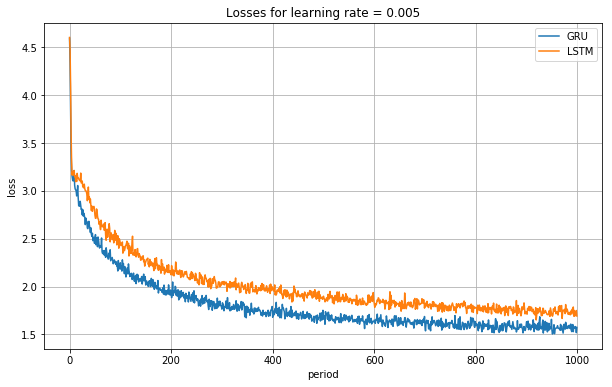

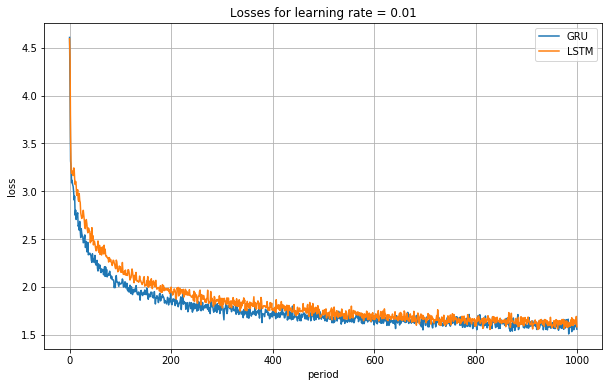

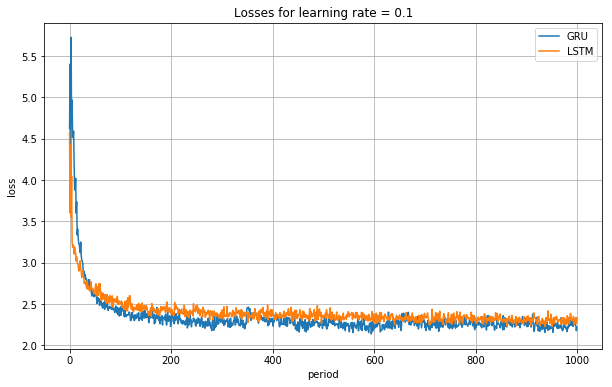

In [250]:
all_losses = np.array(eval_df.all_losses[0])
x = np.arange(0, all_losses.shape[0])

for lr in [0.005, 0.01, 0.1]:

    plt.figure(figsize=(10,6))
    plt.plot(x, eval_df[((eval_df.learning_rate == lr) & (eval_df.model == 'gru'))].all_losses.values[0], 
             label='GRU')
    plt.plot(x, eval_df[((eval_df.learning_rate == lr) & (eval_df.model == 'lstm'))].all_losses.values[0], 
             label='LSTM')
    plt.xlabel('period')
    plt.ylabel('loss')
    plt.title('Losses for learning rate = '+str(lr))
    plt.legend()

    plt.grid()
    plt.show()

## Different hidden_size

In [363]:
condition = ((eval_df.model == 'gru') 
             & (eval_df.n_layers == 2)
             & (eval_df.learning_rate == 0.005)
             & (eval_df.chunk_len == 150)
             & (eval_df.batch_size == 40))
df = eval_df[condition]

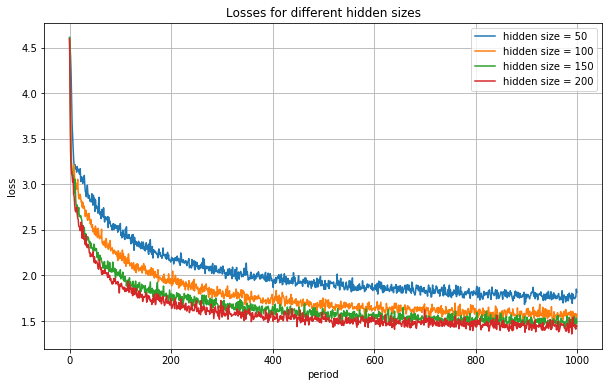

In [366]:
x = np.arange(0, n_epochs)

plt.figure(figsize=(10,6))

for hs in [50, 100, 150, 200]:
    plt.plot(x, df[df.hidden_size == hs].all_losses.values[0], 
             label='hidden size = '+str(hs))
plt.xlabel('period')
plt.ylabel('loss')
plt.title('Losses for different hidden sizes')
plt.legend()

plt.grid()
plt.show()

## Different n_layers

In [369]:
condition = ((eval_df.model == 'gru') 
             & (eval_df.hidden_size == 100)
             & (eval_df.learning_rate == 0.005)
             & (eval_df.chunk_len == 150)
             & (eval_df.batch_size == 40))
df = eval_df[condition]

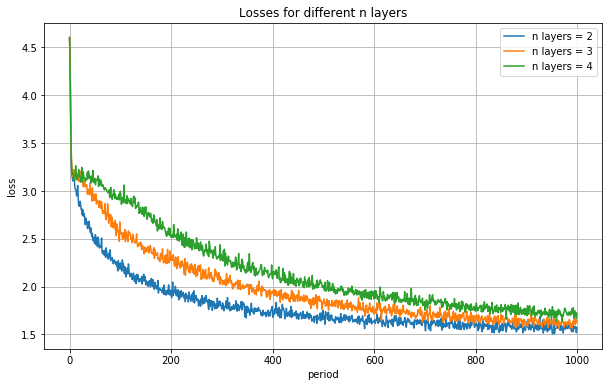

In [370]:
x = np.arange(0, n_epochs)

plt.figure(figsize=(10,6))

for nl in [2, 3, 4]:
    plt.plot(x, df[df.n_layers == nl].all_losses.values[0], 
             label='n layers = '+str(nl))
plt.xlabel('period')
plt.ylabel('loss')
plt.title('Losses for different n layers')
plt.legend()

plt.grid()
plt.show()

## Different chunk_len

In [373]:
condition = ((eval_df.model == 'gru') 
             & (eval_df.hidden_size == 100)
             & (eval_df.learning_rate == 0.005)
             & (eval_df.n_layers == 2)
             & (eval_df.batch_size == 40))
df = eval_df[condition]

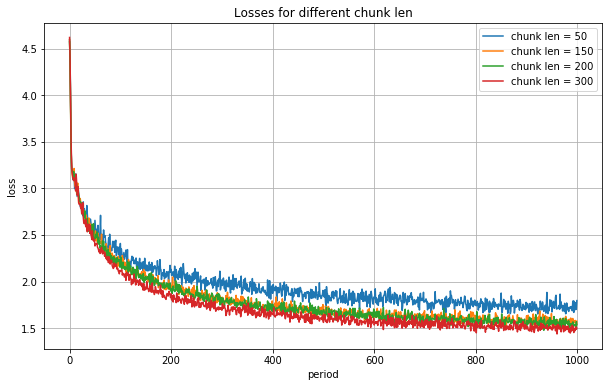

In [374]:
x = np.arange(0, n_epochs)

plt.figure(figsize=(10,6))

for cl in [50, 150, 200, 300]:
    plt.plot(x, df[df.chunk_len == cl].all_losses.values[0], 
             label='chunk len = '+str(cl))
plt.xlabel('period')
plt.ylabel('loss')
plt.title('Losses for different chunk len')
plt.legend()

plt.grid()
plt.show()

## Different batch_size

In [377]:
condition = ((eval_df.model == 'gru') 
             & (eval_df.hidden_size == 100)
             & (eval_df.learning_rate == 0.005)
             & (eval_df.n_layers == 2)
             & (eval_df.chunk_len == 150))
df = eval_df[condition]

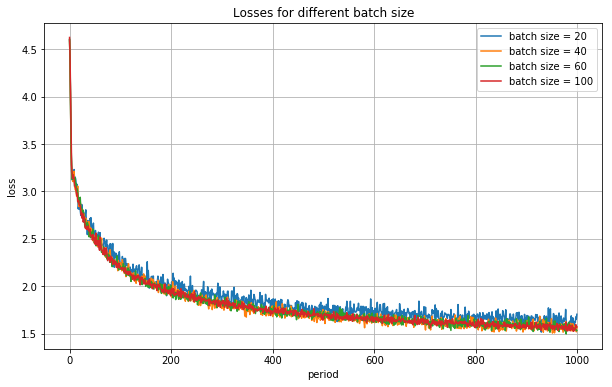

In [378]:
x = np.arange(0, n_epochs)

plt.figure(figsize=(10,6))

for bs in [20, 40, 60, 100]:
    plt.plot(x, df[df.batch_size == bs].all_losses.values[0], 
             label='batch size = '+str(bs))
plt.xlabel('period')
plt.ylabel('loss')
plt.title('Losses for different batch size')
plt.legend()

plt.grid()
plt.show()

# Sampling

In [388]:
#
# TODO: Here is an example of sampling from the trained network. The parameter `temperature` can
# be tuned to vary the probability distribution from which we sample, like before.
# Pass in different values and print a few samples with each. What's the difference?
# Do you notice a difference in quality for the same text with similar hyperparameters
# between the LSTM / GRU and the naive implementation from last week?
#

# Example of sampling:
for temp in [0.2, 0.5, 1, 1.5]:
    print('temperature =', temp)
    print('--------------------')
    for i in range(3):
        print(generate(decoder, prime_str='A', predict_len=200, temperature=temp), '\n')
        print('--------------------')

temperature = 0.2
--------------------
And the states and the consideration of the consideration of the converses of the consideration of the states and the count of the struggle of the count of the second of the convention of the states an 

--------------------
And the consideration of the consideration of the consideration of the states to the consideration of the country should be an army and the serves of the consideration of the country of the same of the 

--------------------
And the free to the same a prove the property from the consideration of the countess of the consideration of the country and the states and the conversation of the carried the considers of the consider 

--------------------
temperature = 0.5
--------------------
And an or the war felt the army and a governs and a sollow social contrain and and the arms
single of the said the farther understand that the see the consideration of the passing and take parches of t 

--------------------
And the suppose the en

In [393]:
#
# TODO: You can also make the `prime_str` parameter longer. Try making it a word or phrase and see if the completion
# is reasonable.
#
for begin in ['Bo', 'La', 'Sh', 'Lake', 'Christmas', 'Holidays are coming', 'I want to ma']:
    print('          ' + begin)
    for temp in [0.5, 1]:
        print('temperature =', temp)
        print('--------------------')
        print(generate(decoder, prime_str=begin, predict_len=200, temperature=temp), '\n')
        print('--------------------')

          Bo
temperature = 0.5
--------------------
Bount of his came a should be all the position of the man of the dear man to the expression in the states to the one of on an usually seemed to be a son the such as a could not be a should contrained. T 

--------------------
temperature = 1
--------------------
Botchants of our Moscow, they head whole could to cap, placed the streep.

The pebactle and the doctor to of a since. Yes for the inncocess which he conversaty gened to they dangteness a pew," begone, a 

--------------------
          La
temperature = 0.5
--------------------
Lare of the prosession of the articular hapince to seemed the considers were constitutions of the laid of the frees, and the part of the sound of the could be control to seemed of the other of the contr 

--------------------
temperature = 1
--------------------
Lar Revielatycalles, Phenes, canliverse, but issadd of it, revouration is long of the Nainis into
Mations quicken. The jouvershes contrabe, she 

# References

This code is based on the following Python package:

- https://github.com/spro/char-rnn.pytorch